## Team member and Contributions
> Shu Xu (shuxu3@illinois.edu): Part I, Implement Lasso

> Yan Han (yanhan4@illinois.edu): Part II

> Amrit Kumar(amritk2@illinois.edu): Part II

**We finish this notebook together.**

## Part I: Implement Lasso
**One-variable Lasso**

First, write a function <em>one_var_lasso</em> that takes the following inputs:
$$
    {\bf v} = (v_1, ..., v_n)^t, {\bf z} = (z_1, ..., z_n)^t, \lambda > 0
$$
and solves the following one-variable Lasso problem:
$$
    \min_b \frac{1}{2n} \sum_{i=1}^{n} (v_i - bz_i)^2 + \lambda |b| =  \min_b \frac{1}{2n} \|{\bf v} - b \cdot {\bf z}\| + \lambda|b|
$$



**The CD Algorithm**

Next, write your own function <em>MyLasso</em> to implement the **Coordinate Descent (CD)** algorithm by repeatedly calling <em>one_var_lasso.</em>

In the CD algorithm, at each iteration, we solve a one-variable Lasso problem for $\beta_j$, while holding the other (p-1) coefficients at their current values:
$$
    \min_{\beta_j} \frac{1}{2n} \sum_{i=1}^{n} (y_i - \sum_{k \neq j} x_{ik} \beta_k - x_{ij}\beta_j)^2 + \lambda \sum_{k \neq j} |\beta_k| + \lambda |\beta_j|
$$
which is equivalent to solving the following one-variable Lasso problem
$$
    \min_{\beta_j} \frac{1}{2n} \sum_{i=1}^{n} (v_i - x_{ij}\beta_j)^2 + \lambda |\beta_j|, v_i = y_i - \sum_{k \neq j} x_{ik}\beta_k
$$

**Test Your Function**

Test your function <em>MyLasso</em> on the data set <u>Coding2_Data.csv</u> with a specific lambda sequence (see the sample code).

Your function should output estimated Lasso coefficients similar to the ones returned by R with option <u>standardized = TRUE</u>. The maximum difference between the two coefficient matrices should be **less than 0.005**.

**Load Data**

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
myData = pd.read_csv("Coding2_Data.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [12]:
X.shape, len(y)

((506, 13), 506)

**CD for Lasso**

In [13]:
def one_var_lasso(r, x, lam):
    
    #################
    # Your CODE
    #################
    n = len(x)
    xTx = np.dot(x.T, x)
    xTr = np.dot(x.T, r)

    # From "OnVarLass.pdf", where b is the minimizer, i.e., x_star
    a = xTr/xTx
    eta = 2 * n * lam/xTx
    second_term = abs(a) - eta/2 # second term in Equation(2) 
    if second_term < 0:
        second_term = 0
    b = np.sign(a) * second_term
    return b

In [14]:
def MyLasso(X, y, lam_seq, maxit = 100):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 

  
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    ##############################
    # YOUR CODE: 
    # (1) newX = Standardizad X; 
    # (2) Record the centers and scales used in (1) 
    ##############################
    y_mean = np.mean(y)
    X_mean = np.mean(X, axis = 0)
    X_std = np.std(X, axis = 0) 
    newX = (X - X_mean) / X_std

    
    # no need to center y
    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y
    
    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
    
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[0, :]
    ##############################
    coeff = (B[1:, :].T/X_std).T  # watch out for the dimension match
    B[0, :] = y_mean - np.dot(X_mean[None, :], coeff)
    B[1:, :] = coeff
    
    return B

In [15]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.3099945835128524, 0.4997421988480499)

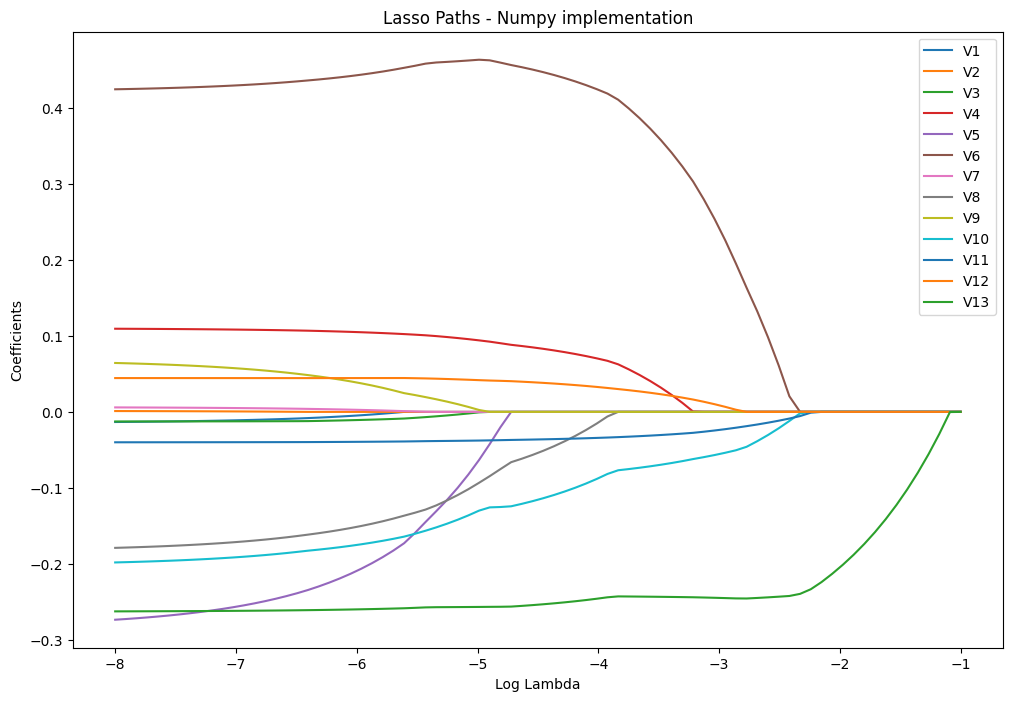

In [16]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

**Check the Accuracy**

Compare the accuracy of your algorithm against the output from glmnet. The maximum difference between the two coefficient matrices should be less than 0.005.

In [17]:
lasso_coef = pd.read_csv("Coding2_lasso_coefs.csv").to_numpy()
lasso_coef.shape

(14, 80)

In [18]:
abs(myout - lasso_coef).max()

0.004645317415906014